In [243]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [244]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [245]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [246]:
from langgraph.graph import StateGraph 
from langgraph.graph import START, END

In [247]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.tools.tavily import TavilySearch

In [248]:
from langchain_openai import ChatOpenAI

In [249]:
from langchain_teddynote.graphs import visualize_graph

In [250]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [251]:
######### 2. 도구 정의 및 바인딩 #########

tool = TavilySearch(max_results=1)
tools = [tool]

In [252]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

llm_with_tools = llm.bind_tools(tools)

In [253]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state['messages'])

    print('=================================================================================')
    print(f'chatbot() 실행\n')
    print(f"[1] state[messages]: \n{state['messages']}\n")
    # print(f'[2] chatbot answer: \n', answer , "\n")
    print(f'[2] chatbot answer: \n', answer.content)
    print(f'[3] answer.additional_kwargs: \n', answer.additional_kwargs)
    print('=================================================================================')

    return {'messages': [answer]}

In [254]:
graph_builder = StateGraph(State)

In [255]:
graph_builder.add_node('chatbot', chatbot)

In [256]:
tool_node = ToolNode(tools=[tool])

In [257]:
graph_builder.add_node('tools', tool_node)

In [258]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [259]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [260]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [261]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [262]:
graph = graph_builder.compile(checkpointer=memory)

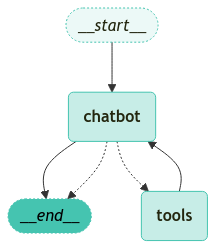

In [263]:
visualize_graph(graph)

In [264]:
from langchain_core.runnables import RunnableConfig

In [265]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'}
)

In [266]:
question = ('`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    
    print('[event] 실행 결과')

    for value in event.values():
        print('[value]: ')
        print(value['messages'][-1])
        
        print(f"\t[content]: {value['messages'][-1].content}")

        print(f"\t[additional_kwargs]: ")
        print(f"\t\t{value['messages'][-1].additional_kwargs}")

        print('\t\t[token_usage]: ')
        # print(f"\t\t\t {value['messages'][-1].response_metadata['token_usage']}")
        print(f"\t\t\t[completion_tokens]: {value['messages'][-1].response_metadata['token_usage']['completion_tokens']}")
        print(f"\t\t\t[prompt_tokens]: {value['messages'][-1].response_metadata['token_usage']['prompt_tokens']}")
        print(f"\t\t\t[total_tokens]: {value['messages'][-1].response_metadata['token_usage']['total_tokens']}")
        print(f"\t\t\t[completion_tokens_details]: {value['messages'][-1].response_metadata['token_usage']['completion_tokens_details']}")
        print(f"\t\t\t[prompt_tokens_details]: {value['messages'][-1].response_metadata['token_usage']['prompt_tokens_details']}")

        print(f"\t\t[model_name]: {value['messages'][-1].response_metadata['model_name']}")
        print(f"\t\t[system_fingerprint]: {value['messages'][-1].response_metadata['system_fingerprint']}")
        print(f"\t\t[finish_reason]: {value['messages'][-1].response_metadata['finish_reason']}")        
        
        print('\t[id]: ')
        print(f"\t\t {value['messages'][-1].id}")

        
        print('\t[usage_metadata]: ')
        print(f"\t\t[input_tokens]: {value['messages'][-1].usage_metadata['input_tokens']}")
        print(f"\t\t[output_tokens]: {value['messages'][-1].usage_metadata['output_tokens']}")
        print(f"\t\t[total_tokens]: {value['messages'][-1].usage_metadata['total_tokens']}")
        print(f"\t\t[input_token_details]: {value['messages'][-1].usage_metadata['input_token_details']}")
        print(f"\t\t[output_token_details]: {value['messages'][-1].usage_metadata['output_token_details']}")

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='c0087c2b-23c6-4356-a867-ad6fe85bf283')]

[2] chatbot answer: 
 안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!
[3] answer.additional_kwargs: 
 {'refusal': None}
[event] 실행 결과
[value]: 
content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None} id='run-f0917870-5e43-4023-90b7-d70f6359966a-0' 

In [267]:
question = ('`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='c0087c2b-23c6-4356-a867-ad6fe85bf283'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-f0917870-5e43-4023-90b7-d70f6359966a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 57, 'total_tokens': 167, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning'

In [268]:
# 이어지는 질문
question = "내 이름이 뭐라고 했지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    
    print('[event] 실행 결과')

    for value in event.values():
        print('[value]: ')
        print(value['messages'][-1])
        
        print(f"\t[content]: {value['messages'][-1].content}")

        print(f"\t[additional_kwargs]: ")
        print(f"\t\t{value['messages'][-1].additional_kwargs}")

        print('\t\t[token_usage]: ')
        # print(f"\t\t\t {value['messages'][-1].response_metadata['token_usage']}")
        print(f"\t\t\t[completion_tokens]: {value['messages'][-1].response_metadata['token_usage']['completion_tokens']}")
        print(f"\t\t\t[prompt_tokens]: {value['messages'][-1].response_metadata['token_usage']['prompt_tokens']}")
        print(f"\t\t\t[total_tokens]: {value['messages'][-1].response_metadata['token_usage']['total_tokens']}")
        print(f"\t\t\t[completion_tokens_details]: {value['messages'][-1].response_metadata['token_usage']['completion_tokens_details']}")
        print(f"\t\t\t[prompt_tokens_details]: {value['messages'][-1].response_metadata['token_usage']['prompt_tokens_details']}")

        print(f"\t\t[model_name]: {value['messages'][-1].response_metadata['model_name']}")
        print(f"\t\t[system_fingerprint]: {value['messages'][-1].response_metadata['system_fingerprint']}")
        print(f"\t\t[finish_reason]: {value['messages'][-1].response_metadata['finish_reason']}")        
        
        print('\t[id]: ')
        print(f"\t\t {value['messages'][-1].id}")

        
        print('\t[usage_metadata]: ')
        print(f"\t\t[input_tokens]: {value['messages'][-1].usage_metadata['input_tokens']}")
        print(f"\t\t[output_tokens]: {value['messages'][-1].usage_metadata['output_tokens']}")
        print(f"\t\t[total_tokens]: {value['messages'][-1].usage_metadata['total_tokens']}")
        print(f"\t\t[input_token_details]: {value['messages'][-1].usage_metadata['input_token_details']}")
        print(f"\t\t[output_token_details]: {value['messages'][-1].usage_metadata['output_token_details']}")

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='c0087c2b-23c6-4356-a867-ad6fe85bf283'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-f0917870-5e43-4023-90b7-d70f6359966a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 57, 'total_tokens': 167, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning'

In [269]:
question = "내 이름이 뭐라고 했지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        print(value["messages"][-1])

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='c0087c2b-23c6-4356-a867-ad6fe85bf283'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-f0917870-5e43-4023-90b7-d70f6359966a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 57, 'total_tokens': 167, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning'

In [270]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'}
)

snapshot = graph.get_state(config=config)

In [271]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='c0087c2b-23c6-4356-a867-ad6fe85bf283'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-f0917870-5e43-4023-90b7-d70f6359966a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 57, 'total_tokens': 167, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 

In [273]:
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efef66a-fe5e-6948-800a-bb9d43f2d297'}}

In [274]:
snapshot.values

{'messages': [HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='c0087c2b-23c6-4356-a867-ad6fe85bf283'),
  AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제로 강의를 진행하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 110, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-f0917870-5e43-4023-90b7-d70f6359966a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 57, 'total_tokens': 167, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessag

In [275]:
snapshot.next

()

In [276]:
snapshot.metadata

{'source': 'loop',
 'writes': {'chatbot': {'messages': [AIMessage(content='당신의 이름은 이인환입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 292, 'total_tokens': 304, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-cb032dc5-8ea3-416c-91fe-d66f2d276a2d-0', usage_metadata={'input_tokens': 292, 'output_tokens': 12, 'total_tokens': 304, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}},
 'thread_id': '1',
 'step': 10,
 'parents': {}}

In [277]:
snapshot.metadata['writes']['chatbot']['messages'][0]

AIMessage(content='당신의 이름은 이인환입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 292, 'total_tokens': 304, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-cb032dc5-8ea3-416c-91fe-d66f2d276a2d-0', usage_metadata={'input_tokens': 292, 'output_tokens': 12, 'total_tokens': 304, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [278]:
from langchain_teddynote.messages import display_message_tree

display_message_tree(snapshot.metadata)

    source: "loop"
    writes:
        chatbot:
            messages:
                index [0]
                    content: "당신의 이름은 이인환입니다."
                    additional_kwargs: {"refusal": None}
                    response_metadata:
                        token_usage:
                            completion_tokens: 12
                            prompt_tokens: 292
                            total_tokens: 304
                            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
                            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
                        model_name: "gpt-4o-mini-2024-07-18"
                        system_fingerprint: "fp_00428b782a"
                        finish_reason: "stop"
                        logprobs: None
                    type: "ai"
                    name: None
                    id: "run-cb032dc5-8ea3-416c-91fe-d66f2